In [1]:
BATCH_SIZE=64

In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import torchvision.models

In [3]:
IMG_SIZE=32
transform_normal = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
# 数据增强
transform_aug = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomCrop(IMG_SIZE,IMG_SIZE//8),
    transforms.RandomHorizontalFlip(),
   
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    transforms.RandomErasing()

])

training_data = torchvision.datasets.CIFAR100(root = '../../data',train =True,download=True,transform=transform_aug)
test_data  = torchvision.datasets.CIFAR100(root = '../../data',train=False,download=True,transform=transform_normal)


train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True,drop_last=True,pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE*2, shuffle=False,pin_memory=True)

print(training_data[0][0].shape)

169001984it [08:29, 331554.43it/s]                                


Extracting ../../data\cifar-100-python.tar.gz to ../../data
Files already downloaded and verified
torch.Size([3, 32, 32])


In [4]:
device='cuda' if torch.cuda.is_available() else 'cpu'
device=torch.device(device)

In [5]:
model=torchvision.models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 100)
if IMG_SIZE<=64:
    model.conv1 = nn.Conv2d(model.conv1.in_channels,model.conv1.out_channels,3,1,1)
    model.maxpool = nn.Identity()

In [6]:
def check_acc(model,epoch,epochs):
    _tqdm=tqdm(test_dataloader,total=len(test_dataloader))
    model.eval()
    with torch.no_grad():
        total_num=0
        right_num=0
        model=model.train()
        for img,label in _tqdm:
            img=img.to(device)
            label=label.to(device)
            total_num=total_num+img.shape[0]
            predicted_outputs=model(img)
            right_num         +=   torch.sum(torch.argmax(predicted_outputs,dim=-1)==label)
            acc=right_num/total_num
            _tqdm.set_description_str(f'test {epoch}/{epochs} test acc:{acc*100:.1f}%')
    return acc
    

In [7]:

def train(model,epochs,loss_fn,optimizer,scheduler):
    #loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
 
    #optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
    results=[]
    best_acc=0
    avg_loss=0
    amp_enable=False
    scaler = torch.cuda.amp.GradScaler(enabled=amp_enable)
    for epoch in range(epochs):
        _tqdm=tqdm(train_dataloader,total=len(train_dataloader))
        total_num=0
        right_num=0
        loss_total=0
        model.train()
        for img,label in _tqdm:
            img=img.to(device)
            label=label.to(device)
            total_num=total_num+img.shape[0]
            
            
            optimizer.zero_grad()
            with torch.cuda.amp.autocast(enabled=amp_enable):
                predicted_outputs=model(img)
                train_loss = loss_fn(predicted_outputs, label)   # calculate loss for the predicted output  
                #loss_gap = F.binary_cross_entropy(torch.sigmoid(predicted_outputs_add[:,-1]),cosine_similarity_between_pred)
            

            
            #train_loss.backward()   # backpropagate the loss 
            scaler.scale(train_loss).backward()
            #optimizer.step()        # adjust parameters based on the calculated gradients
            scaler.step(optimizer)
            scaler.update()
            loss_total+=train_loss.item()

            right_num         +=  torch.sum(torch.argmax(predicted_outputs,dim=-1)==label)
            
            acc=right_num/total_num
            _tqdm.set_description_str(f'train {epoch}/{epochs} loss:{train_loss.item():.5f}   acc:{acc*100:.1f}% loss_last:{avg_loss:.5f}')
        train_acc = right_num/total_num
        test_acc=check_acc(model,epoch,epochs)
        avg_loss=loss_total/len(train_dataloader)
        results.append({
            'train_acc':train_acc.item(),
            'test_acc':test_acc.item(),
        })
        if best_acc < test_acc:
            best_acc=test_acc
        
        scheduler.step()
    return results
            
      
        

In [8]:

def plot_result(result,title=None):
    # result: 
    # list of dictionary 
    resulta=np.array([list(item.values()) for item in result])
    plt.plot(resulta)
    plt.legend(result[0].keys())
    plt.grid()
    if title :
        plt.title(title)
    plt.savefig(title+'.jpeg')

In [9]:
def train_and_plot(model,lr=0.1,max_epochs=200):

    model=model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
    optimizer = optim.SGD(model.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
    
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.3)
    result=train(model,max_epochs,loss_fn,optimizer,scheduler)
    name=f'resnet_cifar100_{model.__class__.__name__}_{len(model.state_dict())}_{max_epochs}'
    plot_result(result,name)
    torch.save(model.state_dict(),name+'.pt')
    

train 0/10 loss:1.78589   acc:32.9% loss_last:0.00000: 100%|██████████| 781/781 [01:30<00:00,  8.59it/s]
test 0/10 test acc:54.3%: 100%|██████████| 79/79 [00:03<00:00, 21.39it/s]
train 1/10 loss:1.77193   acc:55.1% loss_last:2.68190: 100%|██████████| 781/781 [00:53<00:00, 14.69it/s]
test 1/10 test acc:62.3%: 100%|██████████| 79/79 [00:03<00:00, 22.79it/s]
train 2/10 loss:1.22386   acc:62.2% loss_last:1.60592: 100%|██████████| 781/781 [00:53<00:00, 14.67it/s]
test 2/10 test acc:65.8%: 100%|██████████| 79/79 [00:03<00:00, 22.45it/s]
train 3/10 loss:0.92663   acc:71.6% loss_last:1.31705: 100%|██████████| 781/781 [00:52<00:00, 14.74it/s]
test 3/10 test acc:72.1%: 100%|██████████| 79/79 [00:03<00:00, 22.73it/s]
train 4/10 loss:0.99734   acc:74.4% loss_last:0.97340: 100%|██████████| 781/781 [00:53<00:00, 14.71it/s]
test 4/10 test acc:72.8%: 100%|██████████| 79/79 [00:03<00:00, 22.71it/s]
train 5/10 loss:0.75995   acc:75.7% loss_last:0.86826: 100%|██████████| 781/781 [00:53<00:00, 14.67it/s]


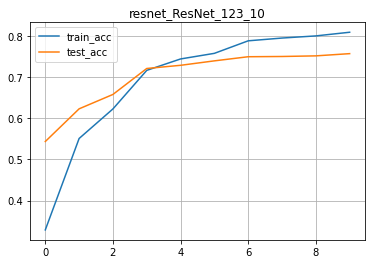

In [10]:
train_and_plot(model,lr=5e-3,max_epochs=10)

In [ ]:
train_and_plot(model,lr=5e-4,max_epochs=10)

In [13]:
torch.save(model.to('cpu'),'resnet18_cifar100_base.pt')

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1